In [2]:
from keras import backend
from pandas import DataFrame
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('/root/data/trainval_data.csv')
df.head(3)

,datetime,temperature,humidity,usage,weekday
0,2019-01-02 00:00:00,0.0,23.9,40.412,2
1,2019-01-02 00:15:00,-0.9,27.0,40.412,2
2,2019-01-02 00:30:00,-1.5,28.5,40.412,2


In [6]:
def minmax_scaler(X, minmax_range):
    scaled = (X - minmax_range[0]) / (minmax_range[1] - minmax_range[0])
    return scaled


def create_dataset(data, data2,look_back=192):
    dataX, dataY = [], []
    for i in range(len(data)-2*look_back):
        dataX.append(data[i:(i+look_back)])
        dataY.append(data2[i+2*(look_back)])
    return np.array(dataX), np.array(dataY)


In [7]:
df = df.interpolate(method='linear', limit_direction='both', axis=0)

train_set = df.iloc[:int(len(df)*0.8)]
test_set = df.iloc[int(len(df)*0.8):]

print(f'전체 데이터 : {len(df)}')
print(f'학습 데이터 : {len(train_set)}')
print(f'시험 데이터 : {len(test_set)}')

전체 데이터 : 25163
학습 데이터 : 20130
시험 데이터 : 5033


In [8]:
pw = np.array(train_set['usage'])
pw = pw.reshape(pw.shape[0],1)
temp = np.array(train_set['temperature'])
temp = temp.reshape(temp.shape[0],1)
humd = np.array(train_set['humidity'])
humd = humd.reshape(humd.shape[0],1)
wday = np.array(train_set['weekday'])
wday = wday.reshape(wday.shape[0],1)

pw = minmax_scaler(pw, [min(pw), max(pw)])
temp = minmax_scaler(temp, [-40,40])
humd = minmax_scaler(humd, [0,100])
wday = minmax_scaler(wday, [0,6])

total = np.hstack([pw,temp,humd,wday])
X_train, y_train = create_dataset(total,pw)

print(X_train.shape)
print(y_train.shape)

model = Sequential()
model.add(LSTM(32,input_shape=(X_train.shape[1],4),return_sequences=True))
model.add(LSTM(32,input_shape=(X_train.shape[1],4)))
# model.add(TimeDistributed(Dense(1)))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=384, verbose=2, shuffle=False)

from keras.models import model_from_json

model_json = model.to_json()
jsonname = 'lstm_model.json'
h5name = 'lstm_model.h5'
with open(jsonname,"w") as json_file:
    json_file.write(model_json)

model.save_weights(h5name)
print("Saved model to disk")
print('finished!')    

(19746, 192, 4)
(19746, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 25s - loss: 0.1590
Epoch 2/50
 - 23s - loss: 0.1398
Epoch 3/50
 - 23s - loss: 0.1303
Epoch 4/50
 - 22s - loss: 0.1241
Epoch 5/50
 - 23s - loss: 0.1231
Epoch 6/50
 - 23s - loss: 0.1219
Epoch 7/50
 - 23s - loss: 0.1227
Epoch 8/50
 - 22s - loss: 0.1249
Epoch 9/50
 - 22s - loss: 0.1221
Epoch 10/50
 - 23s - loss: 0.1239
Epoch 11/50
 - 22s - loss: 0.1191
Epoch 12/50
 - 22s - loss: 0.1201
Epoch 13/50
 - 23s - loss: 0.1170
Epoch 14/50
 - 22s - loss: 0.1162
Epoch 15/50
 - 23s - loss: 0.1130
Epoch 16/50
 - 22s - loss: 0.1102
Epoch 17/50
 - 23s - loss: 0.1083
Epoch 18/50
 - 23s - loss: 0.1078
Epoch 19/50
 - 23s - loss: 0.1089
Epoch 20/50
 - 22s - loss: 0.1120
Epoch 21/50
 - 22s - loss: 0.1155
Epoch 22/50
 - 22s - loss: 0.1120
Epoch 23/50
 - 23s - loss: 0.1046
Epoch 24/50
 - 22s - loss: 0.1074
Epoch 25/50
 - 23s - loss: 0.1030
Epoch 26/50


### 테스트

In [9]:
def inverse_scaler(X,minmax_range):
    inv = X * (minmax_range[1]-minmax_range[0]) + minmax_range[0]
    return inv

In [10]:
pw_range = [min(df['usage']), max(df['usage'])]
pw = np.array(test_set['usage'])
pw = pw.reshape(pw.shape[0],1)

temp = np.array(test_set['temperature'])
temp = temp.reshape(temp.shape[0],1)
humd = np.array(test_set['humidity'])
humd = humd.reshape(humd.shape[0],1)
wday = np.array(test_set['weekday'])
wday = wday.reshape(wday.shape[0],1)

pw = minmax_scaler(pw, pw_range)
temp = minmax_scaler(temp, [-40,40])
humd = minmax_scaler(humd, [0,100])
wday = minmax_scaler(wday, [0,6])

Test = np.hstack([pw,temp,humd,wday])

json_file = open('lstm_model.json',"r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('lstm_model.h5')
model.compile(loss='mse', optimizer='adam')

predictions = []
y_test = []

i = 0; cnt = 0
while (i < len(Test)-384):
    X_test, test_y = create_dataset(Test[i:i+385],pw[i:i+385],192)
    pred = model.predict(X_test)
#     print(pred, end=' ')
    predictions.append(pred)
    y_test.append(test_y)

    i += 1
    cnt += 1
##### inverse transform ##############
y_test = inverse_scaler(np.array(y_test),pw_range)
predictions = inverse_scaler(np.array(predictions),pw_range)
y_test = np.vstack(y_test).squeeze()
predictions = np.vstack(predictions).squeeze()


In [12]:
from datetime import datetime, timedelta

dt_list = []
for i in range(len(test_set)-384):
    dt = datetime.strptime(test_set['datetime'].iloc[i],'%Y-%m-%d %H:%M:%S')
    dt_pred = dt + timedelta(minutes=15*192)
    dt_list.append(datetime.strftime(dt_pred,'%Y-%m-%d %H:%M:%S')[:-9])

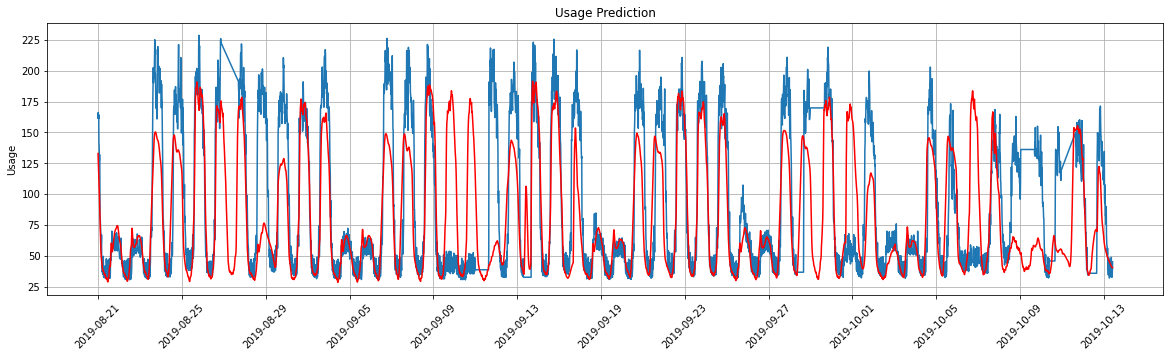

In [14]:
plt.rcParams["figure.figsize"] = (20,5)
plt.grid(True)

plt.ylabel('Usage')
plt.xticks(np.arange(0,len(y_test),step=384),labels=[dt_list[i] for i in range(0,len(dt_list), 384)], rotation=45)
plt.plot(y_test)
plt.plot(predictions,'r')
plt.title('Usage Prediction')
plt.show()  

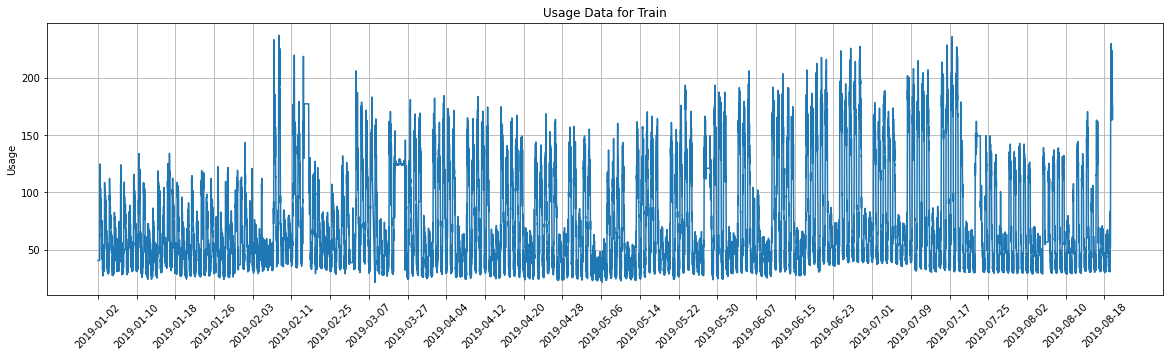

In [15]:
plt.rcParams["figure.figsize"] = (20,5)
plt.grid(True)

plt.ylabel('Usage')
plt.xticks(np.arange(0,len(train_set),step=768),labels=[train_set['datetime'][i][:-9] for i in range(0,len(train_set),768)], rotation=45)
plt.plot(train_set['usage'])
plt.title('Usage Data for Train')
plt.show()  